In [ ]:
import requests
import os
import json
from tqdm.auto import tqdm
from functools import lru_cache
import json
from textwrap import dedent
import editdistance
from redis import StrictRedis
from redis_cache import RedisCache
import pandas as pd
import time
import openai

def read_file(file):
    file = os.path.expanduser(file)
    with open(file) as f:
        return f.read()

def listdir(path):
    return [
        os.path.join(path, i) for i in sorted(os.listdir(path))
    ]

In [3]:
with open('testset.json') as file:
    data = json.load(file)

all_cats = [i['name'] for i in data]

In [4]:
archetypes = ""
for i in data:
    archetypes += f"- '{i['name']}' - {i['description']}\n"

In [5]:
examples = []
for i in data:
    example = i['examples'][1]
    examples.append(
        f"# TASK\n**Character**: {example['character_name']}\n"
        f"**Movie name**: {example['movie_name']}\n"
        f"**Movie summary**: {example['summary']}\n"
        f"---\n"
        f"**Answer**: {i['name']}\n"
    )
    examples[-1] = dedent(examples[-1])
examples = examples[:2]

In [6]:
template = """
You are a movie character analyser. You need to identify the specified movie character archetype based on the character and information about movie (summary, cast, plot). Those are available archetypes:
{archetypes}

Do not hallucinate, this is very important task. For each question output exactly one prediction out of the provided archetypes.

Examples:
{examples}
"""
template = template.format(archetypes=archetypes, examples='\n'.join(examples))

In [7]:
print(template)


You are a movie character analyser. You need to identify the specified movie character archetype based on the character and information about movie (summary, cast, plot). Those are available archetypes:
- 'Love Interest / Romantic Partner' - A character involved in a romantic relationship with a main figure, influencing emotional arcs and sometimes motivating heroic action.
- 'Caregiver / Healer' - Provides nurture, comfort, or medical/spiritual healing; supports others’ well-being and stability.
- 'Mentor / Wise Guide' - Provides knowledge, training, or insight to help the hero or others grow and succeed.
- 'Intellectual / Creative (Scholar/Artist/Inventor)' - Values knowledge, innovation, or art; provides crucial insights, cultural depth, problem-solving, or visionary ideas.
- 'Ruler / Politician' - Holds formal power or influence; shapes policies, alliances, and social orders, whether for good or ill.
- 'Sidekick / Loyal Companion' - A supportive ally, assisting the hero, offering 

In [ ]:
host = "localhost"
port = 6379
client = StrictRedis(host=host, port=port, decode_responses=True, )
cache = RedisCache(redis_client=client, prefix='gpt-load-alex', )

In [9]:
in_mem_cache = {}

In [ ]:

# Set your OpenAI API key
openai.api_key = "your_openai_api_key"

default_model = "gpt-4"
model_switch_threshold = 23000

@cache.cache()
def get_prediction(text, template=template, model="gpt-4", max_tokens=4096, temperature=0.01):
    if template + text in in_mem_cache:
        return in_mem_cache[template + text]

    model = default_model
    if len(text) + len(template) > model_switch_threshold:
        model = "gpt-4"

    messages = [
        {"role": "user", "content": template},
        {"role": "assistant", "content": "Ok, understood. Please provide the task"},
        {"role": "user", "content": text},
    ]

    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            max_tokens=512,
            temperature=0.00001
        )

        return response['choices'][0]['message']['content']

    except openai.error.OpenAIError as e:
        print(f"OpenAI API error: {e}")
        raise

In [11]:
def make_request(**data):
    result = (
        f"# TASK\n**Character**: {data['character_name']}\n"
        f"**Movie name**: {data['movie_name']}\n"
        f"**Movie summary**: {data['summary']}\n"
        f"---\n"
        f"**Answer**: "
    )
    return result

In [12]:
tasks = [
    make_request(
        **example
    )
    for i in data
    for example in i['examples'][1:]
]

targets = [
    i['name']
    for i in data
    for example in i['examples'][1:]
]
chars = [
    example['character_name']
    for i in data
    for example in i['examples'][1:]
]
print(tasks[0])

# TASK
**Character**: Rose DeWitt Bukater
**Movie name**: Titanic
**Movie summary**: In 1996, aboard the research vessel Akademik Mstislav Keldysh, treasure hunter Brock Lovett (Bill Paxton) and his team explore the wreck of RMS Titanic, searching for a valuable diamond necklace called the Heart of the Ocean. The wreck rests on the ocean floor, 3821 meters below the surface. They recover Caledon "Cal" Hockley's (Billy Zane) safe, believing the necklace to be inside, but only find a sketch of a nude woman wearing the diamond, dated April 14, 1912, the night the Titanic hit the iceberg. The expedition is privately funded and hence Brock is under pressure to deliver the diamond to his investors. Hearing about the drawing on the TV news, an elderly woman named Rose Dawson Calvert (Gloria Stuart) calls Lovett and claims that she is the woman depicted in the drawing. She and her granddaughter, Lizzy Calvert (Suzy Amis), visit him and his team on his salvage ship. Rose is 101 years old and al

In [13]:
import joblib

predictions = list(
    get_prediction(i) for i in tqdm(tasks)
)

  0%|          | 0/114 [00:00<?, ?it/s]

In [69]:
def finalize_prediction(gpt_response, all_cats=all_cats):
    if '**Answer**:' in  gpt_response:
        gpt_response = gpt_response.split('**Answer**:')[1]
    result = sorted(all_cats, key=lambda x: editdistance.distance(gpt_response.lower(), x.lower()))[0]
    if result != gpt_response:
        for cat in all_cats:
            if cat in gpt_response:
                return cat
    return result

In [70]:
formatted_preds = [finalize_prediction(resp) for resp in predictions]

In [71]:
sum(i == j for i, j in zip(formatted_preds, targets)) / len(targets)

0.0

In [72]:
with open('summaries.json') as file:
    summaries = json.load(file)

character_data = pd.read_csv('character_processed.csv')

In [73]:
df_for_inference = []

def check_if_summary_contains_name(summary, character_name):
    character_name_parts = character_name.lower().split()
    for part in character_name_parts:
        if part in summary.lower():
            return True
    return False

character_data = character_data[~character_data['Character name'].isna()]

for _, character in character_data.iterrows():
    fb_movie_id = character['Freebase movie ID']
    try:
        summary = summaries[fb_movie_id]['summary']
        movie_name = summaries[fb_movie_id]['name']
    except KeyError:
        continue
    character_name = character['Character name']
    if not check_if_summary_contains_name(summary, character_name):
        continue
    df_for_inference.append({
        'character_name': character['Character name'],
        'movie_name': movie_name,
        'movie_fb_id': fb_movie_id,
        'movie_summary': summary,
        #'characer_fb_id': character['Freebase character ID'], contains nans
        'actor_fb_id': character['Freebase actor ID']
    })

df_for_inference = pd.DataFrame(df_for_inference)

df_for_inference['movie_summary_len'] = df_for_inference.movie_summary.map(lambda x : len(x))
df_for_inference

,character_name,movie_name,movie_fb_id,movie_summary,actor_fb_id,movie_summary_len
0,Lieutenant Melanie Ballard,Ghosts of Mars,/m/03vyhn,"Set in the year 2176, Mars has been 85% terraf...",/m/0346l4,4237
1,Desolation Williams,Ghosts of Mars,/m/03vyhn,"Set in the year 2176, Mars has been 85% terraf...",/m/01vw26l,4237
2,Sgt Jericho Butler,Ghosts of Mars,/m/03vyhn,"Set in the year 2176, Mars has been 85% terraf...",/m/034hyc,4237
3,Bashira Kincaid,Ghosts of Mars,/m/03vyhn,"Set in the year 2176, Mars has been 85% terraf...",/m/01y9xg,4237
4,Commander Helena Braddock,Ghosts of Mars,/m/03vyhn,"Set in the year 2176, Mars has been 85% terraf...",/m/0418ft,4237
...,...,...,...,...,...,...
87458,Card,Alice in Wonderland,/m/085bgh,Alice follows a large white rabbit down a rabb...,/m/0bbytts,1418
87459,White Rabbit,Alice in Wonderland,/m/085bgh,Alice follows a large white rabbit down a rabb...,/m/0kyw2fb,1418
87460,Queen,Alice in Wonderland,/m/085bgh,Alice follows a large white rabbit down a rabb...,/m/0kyw2fb,1418
87461,Gracie,Looking on the Bright Side,/m/05zrrsp,Looking on The Bright Side is a 1932 British m...,/m/01r6mp4,204


In [74]:
df_for_inference = df_for_inference[::-1].copy()

In [75]:
df_for_inference.head()

,character_name,movie_name,movie_fb_id,movie_summary,actor_fb_id,movie_summary_len
87462,Tough Man In Street,Looking on the Bright Side,/m/05zrrsp,Looking on The Bright Side is a 1932 British m...,/m/0bmfmxw,204
87461,Gracie,Looking on the Bright Side,/m/05zrrsp,Looking on The Bright Side is a 1932 British m...,/m/01r6mp4,204
87460,Queen,Alice in Wonderland,/m/085bgh,Alice follows a large white rabbit down a rabb...,/m/0kyw2fb,1418
87459,White Rabbit,Alice in Wonderland,/m/085bgh,Alice follows a large white rabbit down a rabb...,/m/0kyw2fb,1418
87458,Card,Alice in Wonderland,/m/085bgh,Alice follows a large white rabbit down a rabb...,/m/0bbytts,1418


In [76]:
try:
    with open('predictions.json') as file:
        all_data = json.load(file)
except FileNotFoundError:
    all_data = []
len(all_data)

123546

In [77]:
df_for_inference['cache_key'] = df_for_inference['movie_fb_id'] + '_' + df_for_inference['actor_fb_id'] + '_' + df_for_inference['character_name']
already = [i['movie_fb_id'] + '_' + i['actor_fb_id'] + '_' + i['character_name'] for i in all_data if i['original_response'] == i['prediction']]
df_for_inference = df_for_inference[~df_for_inference.cache_key.isin(already)]
df_for_inference.shape

(82, 7)

In [78]:
tasks = [
    make_request(
        character_name=row['character_name'],
        movie_name=row['movie_name'],
        summary=row['movie_summary'],
    )
    for i, row in df_for_inference.iterrows()
]

In [79]:
i = 25
get_prediction(tasks[i]), finalize_prediction(get_prediction(tasks[i]))

('In the movie "Cursed," the character Brooke is primarily depicted as Jimmy\'s crush and becomes involved in the story as a romantic interest. Given this context, Brooke fits the archetype of \'Love Interest / Romantic Partner.\'',
 'Love Interest / Romantic Partner')

In [80]:
predictions = joblib.Parallel(n_jobs=32, backend='threading', return_as='generator')(
    joblib.delayed(get_prediction)(i) for i in tasks
)

last_save = 0
flaky_preds = 0
progress = tqdm(predictions, total=len(tasks))
for task, prediction, (i, row) in zip(tasks, progress, df_for_inference.iterrows()):
    res = dict(
        prediction=finalize_prediction(prediction),
        original_response=prediction,
        character_name=row['character_name'],
        movie_name=row['movie_name'],
        movie_fb_id=row['movie_fb_id'],
        actor_fb_id=row['actor_fb_id'],
        model=default_model if len(task) + len(template) <= model_switch_threshold else 'gpt-4o',
    )
    flaky_preds += int(res['prediction'] != res['original_response'])
    all_data.append(res)
    progress.set_description(f"{len(all_data) = }, {flaky_preds = }", refresh=False)
    if abs(last_save - time.time()) > 60:
        last_save = time.time()
        with open('predictions.json', 'w') as file:
            json.dump(all_data, file)

  0%|          | 0/82 [00:00<?, ?it/s]

In [81]:
with open('predictions.json', 'w') as file:
    json.dump(all_data, file)

In [82]:
df = pd.DataFrame(all_data)
df['model'] = df.model.fillna('gpt-4o')
df.head()

,prediction,original_response,character_name,movie_name,movie_fb_id,actor_fb_id,model
0,Other,Other,Tough Man In Street,Looking on the Bright Side,/m/05zrrsp,/m/0bmfmxw,gpt-4o
1,Love Interest / Romantic Partner,Love Interest / Romantic Partner,Gracie,Looking on the Bright Side,/m/05zrrsp,/m/01r6mp4,gpt-4o
2,Ruler / Politician,Ruler / Politician,Queen,Alice in Wonderland,/m/085bgh,/m/0kyw2fb,gpt-4o
3,Rogue / Trickster / Con Artist,Rogue / Trickster / Con Artist,White Rabbit,Alice in Wonderland,/m/085bgh,/m/0kyw2fb,gpt-4o
4,Sidekick / Loyal Companion,Sidekick / Loyal Companion,Card,Alice in Wonderland,/m/085bgh,/m/0bbytts,gpt-4o


In [94]:
deduplicated = []

for index, data in tqdm(df.groupby(['character_name', 'movie_name', 'movie_fb_id', 'actor_fb_id'])):
    data = data.to_dict('records')
    data = sorted(
        data,
        key=lambda x: x['model'] == 'gpt-4o',
        reverse=True
    )
    data = sorted(
        data,
        key=lambda x: int('# TASK' not in x['original_response']),
        reverse=True
    )
    data = sorted(
        data,
        key=lambda x: int(x['prediction'] == x['original_response']),
        reverse=True
    )
    deduplicated.append(data[0])

deduplicated = pd.DataFrame(deduplicated)

  0%|          | 0/87217 [00:00<?, ?it/s]

In [95]:
deduplicated

,prediction,original_response,character_name,movie_name,movie_fb_id,actor_fb_id,model
0,Mentor / Wise Guide,Mentor / Wise Guide,Umeko Tsuda,Leonie,/m/05zr2p5,/m/0c7tjc,gpt-3.5-turbo
1,Rogue / Trickster / Con Artist,Rogue / Trickster / Con Artist,'2-Gun' Gertie Baxter,Roxie Hart,/m/026l5ym,/m/049wny,gpt-4o
2,Rogue / Trickster / Con Artist,Rogue / Trickster / Con Artist,'A.J.' Furnival,The Groom Wore Spurs,/m/05nszz2,/m/0h7dd,gpt-3.5-turbo
3,Warrior / Vigilante,Warrior / Vigilante,'Ace' Cooper,The Dude Bandit,/m/07s5z0d,/m/05ddzx,gpt-3.5-turbo
4,Warrior / Vigilante,Warrior / Vigilante,'Baby Face' Martin,Dead End,/m/0gnrt,/m/03n6r,gpt-4o
...,...,...,...,...,...,...,...
87212,Other,Other,Öregasszony,Cserepek,/m/064qw9w,/m/064n8zg,gpt-4o
87213,Other,Other,Østergaard,The Castle,/m/04q8y_g,/m/04n2_kz,gpt-4o
87214,Sidekick / Loyal Companion,Sidekick / Loyal Companion,Şaban,Hababam Sınıfı Tatilde,/m/0g5rqxx,/m/02lbb_,gpt-4o
87215,Sidekick / Loyal Companion,Sidekick / Loyal Companion,Şaban,Hababam sinifi,/m/02q9v9h,/m/02lbb_,gpt-3.5-turbo


In [96]:
import gzip

with gzip.open('predictions-alex.csv.gz', 'w') as file:
    deduplicated.to_csv(file, index=False)

In [97]:
deduplicated[deduplicated.original_response != deduplicated.prediction]

,prediction,original_response,character_name,movie_name,movie_fb_id,actor_fb_id,model
657,Outsider / Loner,Accident Witness,Accident Witness,Her Awakening,/m/02vxskw,/m/03bdm4,gpt-3.5-turbo
658,Outsider / Loner,Accident Witness,Accident Witness,Her Awakening,/m/02vxskw,/m/03c1f9m,gpt-3.5-turbo
659,Outsider / Loner,Accident Witness,Accident Witness,Her Awakening,/m/02vxskw,/m/03c2brm,gpt-3.5-turbo
2275,Intellectual / Creative (Scholar/Artist/Inventor),"In the movie ""Investigating Sex,"" Alice is des...",Alice,Investigating Sex,/m/0fbn1l,/m/0l8v5,gpt-3.5-turbo
4473,Love Interest / Romantic Partner,'Other' - Doesn't align with any of the propos...,Anthrax,Calendar Girls,/m/01w8g3,/m/0bj70m7,gpt-3.5-turbo
...,...,...,...,...,...,...,...
82053,Mystic / Seer,Traffic Controller,Traffic Controller,Mr. Bean's Holiday,/m/047v27,/m/0d336cw,gpt-3.5-turbo
83615,Intellectual / Creative (Scholar/Artist/Inventor),"In the movie ""Unforgivable,"" Vicky is the ten-...",Vicky,Unforgivable,/m/0g8p65k,/m/0d28sqm,gpt-3.5-turbo
84173,Intellectual / Creative (Scholar/Artist/Inventor),"In the movie ""Amazon Women on the Moon,"" the c...",Violet,Amazon Women on the Moon,/m/05qr83,/m/01pqy_,gpt-4o
85440,Intellectual / Creative (Scholar/Artist/Inventor),"In the movie ""Paradise,"" Willard Young serves ...",Willard Young,Paradise,/m/0c2xrs,/m/015t56,gpt-3.5-turbo


<Axes: >

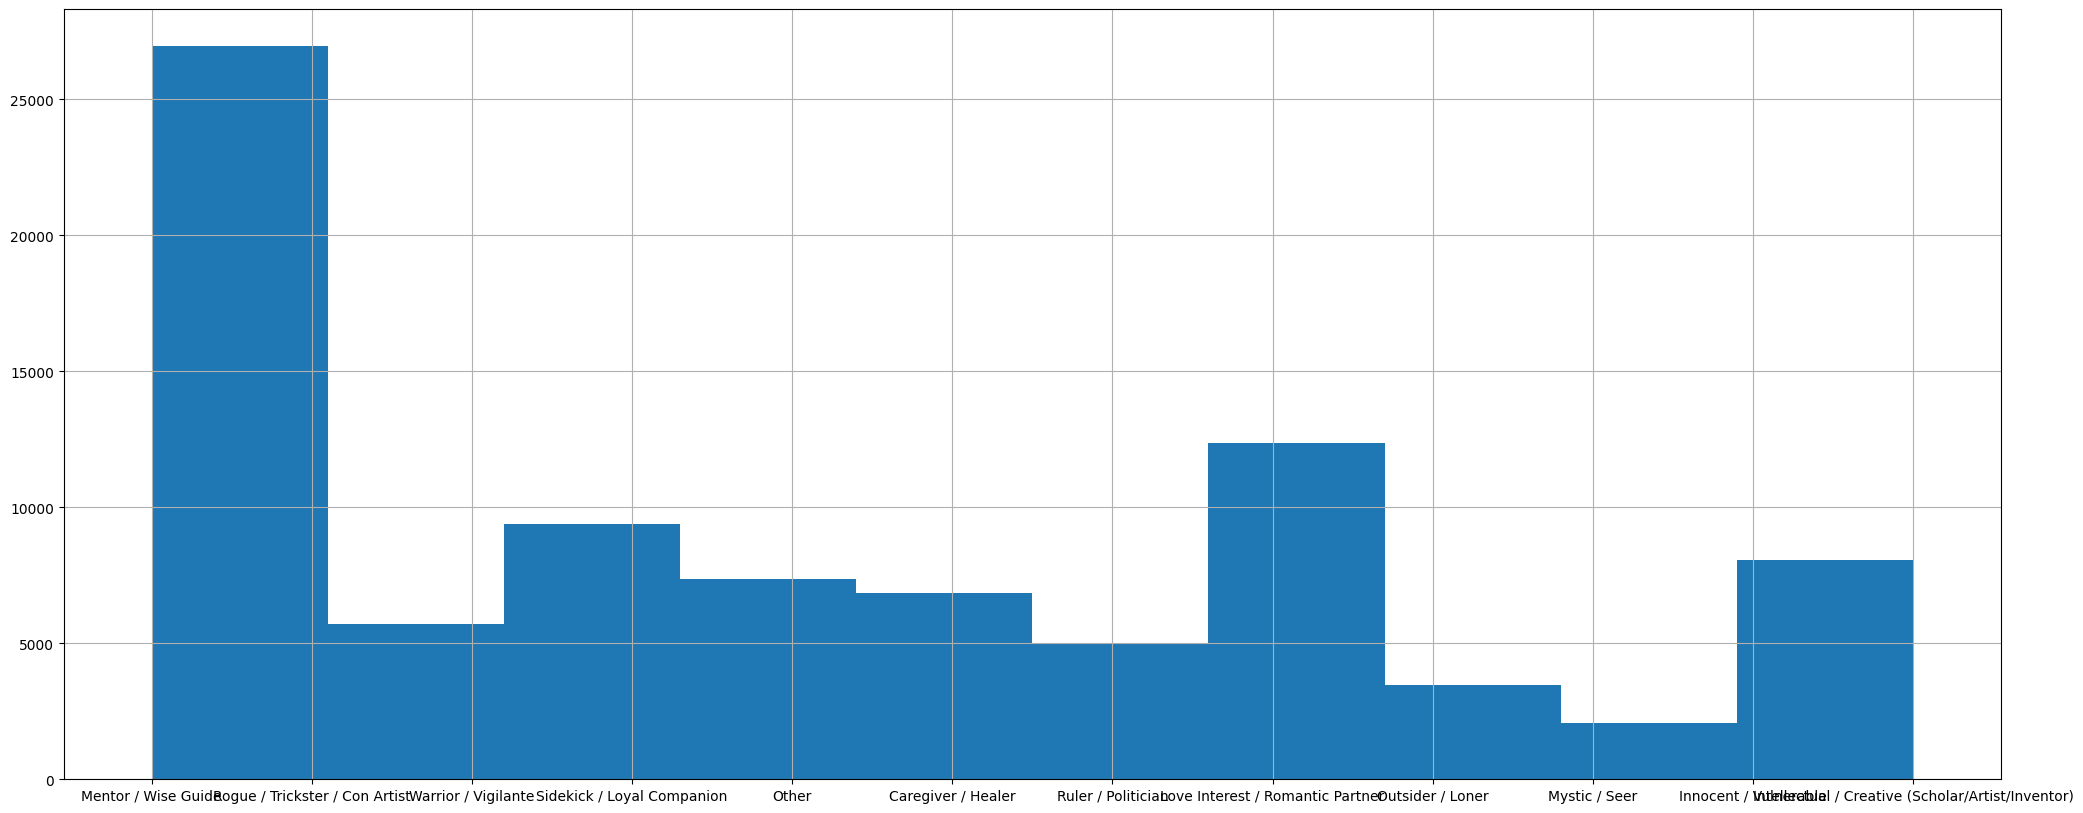

In [100]:
deduplicated.prediction.hist(figsize=(25, 10))